In [1]:
# Chạy thật
import os
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score

from mne import Epochs, pick_types, find_events, pick_types, set_eeg_reference
from mne.channels import read_layout
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from mne import viz

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data_directory = 'PhysioNet_Dataset'

# Danh sách chủ đề và số chạy
subjects = [f"S{i:03d}" for i in range(1, 110) if i not in [87, 88, 92, 99, 100]] # 87 88 92 99 100 bi loi
runs = [f"R{r:02d}" for r in [3,7,11,4,8,12]]  # Task open eyes và closed eyes
print(subjects, runs)
raw_fnames = []

# Lặp qua từng chủ đề và số chạy để lấy các đường dẫn tệp dữ liệu đã tải
for subject in subjects:
    for run in runs:
        # Đường dẫn tệp dữ liệu
        file_path = os.path.join(data_directory, subject, f"{subject}{run}.edf")
        raw_fnames.append(file_path)
    
    # raws.append(concatenate_raws()
raw_list = [mne.io.read_raw_edf(f, preload=True) for f in raw_fnames]

raw_obj1 = concatenate_raws(raw_list)

# raw_fnames = []
# runs = [f"R{r:02d}" for r in [6,10,14]]  # Task open eyes và closed eyes
# for subject in subjects:
#     for run in runs:
#         # Đường dẫn tệp dữ liệu
#         file_path = os.path.join(data_directory, subject, f"{subject}{run}.edf")
#         raw_fnames.append(file_path)
#     
#     # raws.append(concatenate_raws()
#     raw_list = [mne.io.read_raw_edf(f, preload=True) for f in raw_fnames]
# raw_obj2 = concatenate_raws(raw_list)

['S001', 'S002', 'S003', 'S004', 'S005', 'S006', 'S007', 'S008', 'S009', 'S010', 'S011', 'S012', 'S013', 'S014', 'S015', 'S016', 'S017', 'S018', 'S019', 'S020', 'S021', 'S022', 'S023', 'S024', 'S025', 'S026', 'S027', 'S028', 'S029', 'S030', 'S031', 'S032', 'S033', 'S034', 'S035', 'S036', 'S037', 'S038', 'S039', 'S040', 'S041', 'S042', 'S043', 'S044', 'S045', 'S046', 'S047', 'S048', 'S049', 'S050', 'S051', 'S052', 'S053', 'S054', 'S055', 'S056', 'S057', 'S058', 'S059', 'S060', 'S061', 'S062', 'S063', 'S064', 'S065', 'S066', 'S067', 'S068', 'S069', 'S070', 'S071', 'S072', 'S073', 'S074', 'S075', 'S076', 'S077', 'S078', 'S079', 'S080', 'S081', 'S082', 'S083', 'S084', 'S085', 'S086', 'S089', 'S090', 'S091', 'S093', 'S094', 'S095', 'S096', 'S097', 'S098', 'S101', 'S102', 'S103', 'S104', 'S105', 'S106', 'S107', 'S108', 'S109'] ['R03', 'R07', 'R11', 'R04', 'R08', 'R12']
Extracting EDF parameters from D:\Tuda\EEG_Motor_Imagery_Single_Channel\PhysioNet_Dataset\S001\S001R03.edf...
EDF file detec

In [4]:
len(raw_list)

624

In [5]:
# raw_data1 = raw_obj1.get_data()
# print(raw_obj1)
# print(raw_data1)
# data, times = raw_obj1[:-1,:-1]
# 
# fig = plt.subplots(figsize=(10,8))
# plt.plot(times, data.T)
# plt.xlabel('Seconds')
# plt.ylabel('$\mu V$')
# plt.title('Channels: 1-64')
# plt.legend(raw_obj.ch_names)

In [6]:
# raw_data2 = raw_obj2.get_data()
# print(raw_obj2)
# print(raw_data2)
# data, times = raw_obj2[:-1,:-1]
# 
# fig = plt.subplots(figsize=(10,8))
# plt.plot(times, data.T)
# plt.xlabel('Seconds')
# plt.ylabel('$\mu V$')
# plt.title('Channels: 1-64')
# plt.legend(raw_obj.ch_names)

In [5]:
ch_names = raw_obj1.ch_names
ch_names = [ x.replace(".","") for x in ch_names]
ch_names = [ x.upper() for x in ch_names]
print(ch_names)
# print(raw_obj1)
# print(raw_obj2)

['FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'FP1', 'FPZ', 'FP2', 'AF7', 'AF3', 'AFZ', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POZ', 'PO4', 'PO8', 'O1', 'OZ', 'O2', 'IZ']


In [6]:
import pandas as pd
df1 = raw_obj1.to_data_frame()
len(df1)
print(df1.columns)

Index(['time', 'Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..',
       'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.',
       'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.',
       'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..',
       'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.',
       'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..',
       'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..',
       'O2..', 'Iz..'],
      dtype='object')


In [15]:
# import pandas as pd
# df2 = raw_obj2.to_data_frame()
# print(df2.columns)
# df2_cz=df2['Cz..']
# plt.plot(df2['Cz..'])
# plt.show()
# plt.plot(df2['C3..'])
# plt.show()

In [7]:
events, event_ids = mne.events_from_annotations(raw_obj1, event_id='auto')

Used Annotations descriptions: ['T0', 'T1', 'T2']


In [8]:
print(df1.columns)

Index(['time', 'Fc5.', 'Fc3.', 'Fc1.', 'Fcz.', 'Fc2.', 'Fc4.', 'Fc6.', 'C5..',
       'C3..', 'C1..', 'Cz..', 'C2..', 'C4..', 'C6..', 'Cp5.', 'Cp3.', 'Cp1.',
       'Cpz.', 'Cp2.', 'Cp4.', 'Cp6.', 'Fp1.', 'Fpz.', 'Fp2.', 'Af7.', 'Af3.',
       'Afz.', 'Af4.', 'Af8.', 'F7..', 'F5..', 'F3..', 'F1..', 'Fz..', 'F2..',
       'F4..', 'F6..', 'F8..', 'Ft7.', 'Ft8.', 'T7..', 'T8..', 'T9..', 'T10.',
       'Tp7.', 'Tp8.', 'P7..', 'P5..', 'P3..', 'P1..', 'Pz..', 'P2..', 'P4..',
       'P6..', 'P8..', 'Po7.', 'Po3.', 'Poz.', 'Po4.', 'Po8.', 'O1..', 'Oz..',
       'O2..', 'Iz..'],
      dtype='object')


Tách dữ liệu 1 điện cực ra để dự đoán. Nếu dùng cả 64 điện cực thì kq sẽ tốt hơn nhưng sẽ đắt đỏ với cồng kềnh hơn.

In [9]:
# Tiếp tục với phần code hiện tại
t1 = []
t2 = []
t3 = []
electrode = 'C3..'
for i in range(len(events)-1):
    if len(df1[electrode][events[i][0]:events[i+1][0]].values) == 656:
        print(events[i][2])
        if events[i][2] == 1:
            t1.append(df1[electrode][events[i][0]:events[i+1][0]].values)
        if events[i][2] == 2:
            t2.append(df1[electrode][events[i][0]:events[i+1][0]].values)
        if events[i][2] == 3:
            t3.append(df1[electrode][events[i][0]:events[i+1][0]].values)
        
t1 = np.array(t1, dtype=int)
t2 = np.array(t2, dtype=int)
t3 = np.array(t3, dtype=int)
# for i in range(len(t3)):
#     print(len(t1[i]), len(t2[i]), len(t3[i]))

3
2
2
3
3
2
2
3
2
3
3
2
2
3
2
3
2
3
2
3
3
2
2
3
3
2
3
2
2
3
3
2
3
2
2
3
3
2
2
3
3
2
3
2
2
3
3
2
3
2
3
2
2
3
2
3
2
3
2
3
2
3
2
3
3
2
2
3
3
2
3
2
3
2
2
3
3
2
2
3
3
2
3
2
1
2
1
3
1
3
1
2
1
2
1
3
1
3
1
2
1
3
1
2
1
2
1
3
1
2
1
3
1
2
1
3
1
2
1
3
1
2
1
3
1
2
1
2
1
3
1
2
1
3
1
2
1
3
1
3
1
2
1
3
1
3
1
2
1
2
1
3
1
2
1
3
1
3
1
2
1
2
1
3
1
2
1
3
1
3
1
2
1
2
1
2
1
3
1
2
1
3
1
2
1
3
1
3
1
2
1
3
1
2
1
3
1
2
1
3
1
2
1
3
1
2
1
3
1
3
1
2
1
3
1
2
1
3
1
2
1
3
1
2
1
3
1
2
1
2
1
3
1
2
1
2
1
3
1
3
1
2
1
3
1
2
1
2
1
3
1
3
1
2
1
3
1
2
1
2
1
3
1
2
3
2
3
2
2
3
3
2
2
3
2
3
3
2
2
3
2
3
2
3
3
2
2
3
3
2
3
2
2
3
2
3
3
2
3
2
2
3
2
3
2
3
3
2
3
2
3
2
2
3
2
3
2
3
3
2
2
3
2
3
3
2
2
3
3
2
2
3
3
2
3
2
3
2
2
3
2
3
3
2
2
3
2
3
1
3
1
2
1
3
1
2
1
2
1
3
1
2
1
3
1
3
1
2
1
3
1
2
1
3
1
2
1
3
1
3
1
2
1
2
1
3
1
2
1
3
1
3
1
2
1
3
1
2
1
2
1
3
1
3
1
2
1
3
1
2
1
3
1
3
1
2
1
2
1
3
1
2
1
3
1
2
1
3
1
2
1
3
1
3
1
2
1
2
1
2
1
3
1
2
1
3
1
2
1
3
1
3
1
2
1
3
1
2
1
2
1
3
1
3
1
2
1
2
1
2
1
3
1
3
1
2
1
3
1
2
1
2
1
3
1
2
1
3
1
3
1
2
1
3
1
2
1
3
1
2


T0 là rest, T1 là Left, T2 là Right

Cắt đi những phần thừa để đưa dữ liệu vào dataframe

In [10]:
# Find the length of the smallest list
min_length = min(len(t1), len(t2), len(t3))

# Trim the lists to the length of the smallest list
t1_trimmed = t1[:min_length]
t2_trimmed = t2[:min_length]
t3_trimmed = t3[:min_length]

Thu được file csv của 1 điện cực, đã gộp các subject lại với nhau. Cấu trúc là mỗi hàng là dữ liệu sóng não của 1 task diễn ra trong 4.1s, tần số lấy mẫu 160 mẫu 1 giây, cột cuối là label.

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Prepare the data
len(t1_trimmed)
df11 = pd.DataFrame(t1_trimmed)
df2 = pd.DataFrame(t2_trimmed)
df3 = pd.DataFrame(t3_trimmed)

df = pd.concat([df11, df2, df3], axis=0, ignore_index=True)

# Gán cột 'Label' trong DataFrame 'df' bằng danh sách nhãn 'labels'
df['Label'] = [0] * len(t1_trimmed) + [1] * len(t2_trimmed) + [2] * len(t3_trimmed)
df.to_csv("dataC3_full_3_label_both_imagine_real.csv", index=False)
df

,0,1,2,3,4,5,6,7,8,9,...,647,648,649,650,651,652,653,654,655,Label
0,5,2,12,22,20,7,-10,0,-5,-20,...,-23,-42,-44,-24,-6,14,7,-5,-13,0
1,-14,-24,-27,-27,2,-7,10,2,-10,-6,...,80,59,48,59,63,52,12,-8,-28,0
2,14,21,23,8,8,16,16,32,20,9,...,54,83,56,6,-1,-2,26,18,10,0
3,-6,-18,2,9,-7,9,6,12,-3,-14,...,-7,2,14,7,0,-1,1,-5,1,0
4,10,32,21,26,18,31,13,6,2,13,...,-51,-29,-22,-14,-14,-5,8,28,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13573,18,34,42,37,27,29,49,42,52,53,...,-51,-48,-42,-31,-29,-31,-29,-31,-34,2
13574,59,54,35,34,40,46,53,54,54,70,...,-4,4,4,-6,-20,-13,-1,-1,-8,2
13575,-77,-78,-83,-89,-80,-61,-36,-11,-6,-18,...,9,12,11,13,10,8,16,17,12,2
13576,37,21,12,8,6,-5,-17,-27,-26,-20,...,1,6,11,11,14,14,26,29,34,2


EDA Data

In [15]:
# from pandas_profiling import ProfileReport
# df = pd.read_csv('data.csv') 
# profile = ProfileReport(df, title="Pandas Profiling Report for EEG Motor Imagery")

Feature extraction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
df = pd.read_csv("dataC3.csv")

In [2]:
train = df.drop('Label',axis=1)
labels = df['Label']

In [3]:
len(train)

6768

In [4]:
import scipy as sp
import os
import numpy as np
import matplotlib.pyplot as plt
def FeatureExtract(data, fs):
    f, t, Zxx = sp.signal.stft(data, fs, nperseg=len(data)/fs * fs, noverlap=len(data)/fs * fs-1)
    fig, ax2 = plt.subplots(figsize=(3,3))
    ax2.pcolormesh(t, f, np.abs(Zxx), vmin=-1, vmax=5, shading='auto')
    ax2.axis('off')
    ax2.set_ylim(0.5, 40)
    return

11


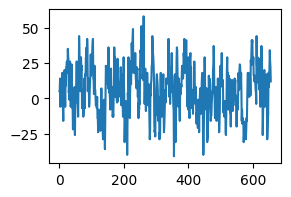

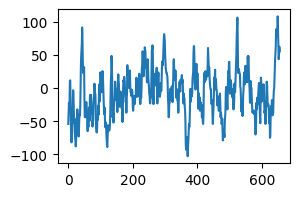

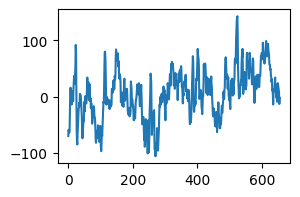

ValueError: invalid literal for int() with base 10: ''

In [7]:
import matplotlib.pyplot as plt
import time

while True:
    i = int(input())
    print(i)

    # Đồ thị miền thời gian cho task "rest"
    plt.figure(figsize=(3, 2))  # Kích thước 6x4 inches
    plt.plot(train.iloc[i].values)
    plt.show()

    # Đồ thị miền thời gian cho task "left"
    plt.figure(figsize=(3, 2))
    plt.plot(train.iloc[i+2256].values)
    plt.show()

    # Đồ thị miền thời gian cho task "right"
    plt.figure(figsize=(3, 2))
    plt.plot(train.iloc[i+2256*2].values)
    plt.show()

    time.sleep(0.5)

In [7]:
len(train)

5652

Chuyển qua STFT để đưa vào thử đánh giá với model CNN (LSTM thì tới đoạn này là hết)

In [10]:
# print(train.iloc[1,:].values)
fs=160
# len(train)
for i in range(len(train)):
    data = train.iloc[i,:].values
    if labels[i] == 0 and not(os.path.exists(f'STFT_images2/{0}/spectrogram{i}.png')):
        print(i,labels[i])
        f, t, Zxx = sp.signal.stft(data, fs, nperseg=len(data)/fs * fs, noverlap=len(data)/fs * fs-1)
        fig, ax2 = plt.subplots(figsize=(3,3))
        ax2.pcolormesh(t, f, np.abs(Zxx), vmin=-1, vmax=5, shading='auto')
        ax2.axis('off')
        ax2.set_ylim(0.5, 40)
        plt.savefig(f'STFT_images2/{0}/spectrogram{i}.png', dpi=100, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        
    if labels[i] == 1 and not(os.path.exists(f'STFT_images2/{1}/spectrogram{i}.png')):
        print(i,labels[i])
        f, t, Zxx = sp.signal.stft(data, fs, nperseg=len(data)/fs * fs, noverlap=len(data)/fs * fs-1)
        fig, ax2 = plt.subplots(figsize=(3,3))
        ax2.pcolormesh(t, f, np.abs(Zxx), vmin=-1, vmax=5, shading='auto')
        ax2.axis('off')
        ax2.set_ylim(0.5, 40)
        plt.savefig(f'STFT_images2/{1}/spectrogram{i}.png', dpi=100, bbox_inches='tight', pad_inches=0)
        plt.close(fig)
        
    if labels[i] == 2 and not(os.path.exists(f'STFT_images2/{2}/spectrogram{i}.png')):
        print(i,labels[i])
        f, t, Zxx = sp.signal.stft(data, fs, nperseg=len(data)/fs * fs, noverlap=len(data)/fs * fs-1)
        fig, ax2 = plt.subplots(figsize=(3,3))
        ax2.pcolormesh(t, f, np.abs(Zxx), vmin=-1, vmax=5, shading='auto')
        ax2.axis('off')
        ax2.set_ylim(0.5, 40)
        plt.savefig(f'STFT_images2/{2}/spectrogram{i}.png', dpi=100, bbox_inches='tight', pad_inches=0)
        plt.close(fig)

2865 1
2866 1
2867 1
2868 1
2869 1
2870 1
2871 1
2872 1
2873 1
2874 1
2875 1
2876 1
2877 1
2878 1
2879 1
2880 1
2881 1
2882 1
2883 1
2884 1
2885 1
2886 1
2887 1
2888 1
2889 1
2890 1
2891 1
2892 1
2893 1
2894 1
2895 1
2896 1
2897 1
2898 1
2899 1
2900 1
2901 1
2902 1
2903 1
2904 1
2905 1
2906 1
2907 1
2908 1
2909 1
2910 1
2911 1
2912 1
2913 1
2914 1
2915 1
2916 1
2917 1
2918 1
2919 1
2920 1
2921 1
2922 1
2923 1
2924 1
2925 1
2926 1
2927 1
2928 1
2929 1
2930 1
2931 1
2932 1
2933 1
2934 1
2935 1
2936 1
2937 1
2938 1
2939 1
2940 1
2941 1
2942 1
2943 1
2944 1
2945 1
2946 1
2947 1
2948 1
2949 1
2950 1
2951 1
2952 1
2953 1
2954 1
2955 1
2956 1
2957 1
2958 1
2959 1
2960 1
2961 1
2962 1
2963 1
2964 1
2965 1
2966 1
2967 1
2968 1
2969 1
2970 1
2971 1
2972 1
2973 1
2974 1
2975 1
2976 1
2977 1
2978 1
2979 1
2980 1
2981 1
2982 1
2983 1
2984 1
2985 1
2986 1
2987 1
2988 1
2989 1
2990 1
2991 1
2992 1
2993 1
2994 1
2995 1
2996 1
2997 1
2998 1
2999 1
3000 1
3001 1
3002 1
3003 1
3004 1
3005 1
3006 1
3007 1

In [4]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

# Kích thước mới của ảnh spectrogram
new_image_height = 256
new_image_width = 256
num_classes = 3
image_folder = 'STFT_Images2/'
# Hàm resize ảnh spectrogram
def resize_image(image):
    image = image.resize((new_image_width, new_image_height))
    return image

# Hàm load dữ liệu
def load_data():
    images = []
    labels = []
    
    # Lặp qua từng thư mục nhãn
    for label in range(num_classes):
        folder_path = image_folder + str(label) + '/'
        
        # Lặp qua từng file ảnh trong thư mục
        for filename in os.listdir(folder_path):
            # Kiểm tra định dạng file
            if filename.endswith('.png'):
                # Đọc ảnh và chuyển thành mảng numpy
                image = Image.open(os.path.join(folder_path, filename))
                image = image.convert('L')
                # Resize ảnh
                # image = resize_image(image)
                
                image = np.array(image)
                
                # Thêm ảnh và nhãn tương ứng vào danh sách
                images.append(image)
                labels.append(label)
    
    # Chuyển danh sách thành mảng numpy
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

# Load dữ liệu
images, labels = load_data()
print(images.shape)

(5652, 231, 232)
